<a href="https://colab.research.google.com/github/wappints/BikeLaneDETECTION/blob/main/hough_transforms_lane_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Bike Lane Detection in the Roads of Metro Manila**

by AGULTO, Juliana Marie & NORONA, Yeohan Lorenzo



## Import Libraries

In [ ]:
import numpy as np
import cv2 as cv2

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Routine to fix 
def fixColor(image):
    return(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

##Read Image


Image shape: (1080, 1920, 3)


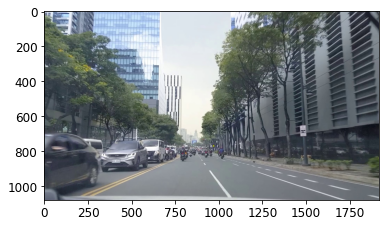

In [ ]:
image = cv2.imread('/content/drive/Shareddrives/Road Physical Feature Extraction/1 | Files/IMAGPRO/Bike lane detection/Data/Capture_2.jpg')
copy_img = image.copy()
print(f"Image shape: {image.shape}")
plt.imshow(fixColor(image))

##Pre-processing

### Increase the image brightness and contrast

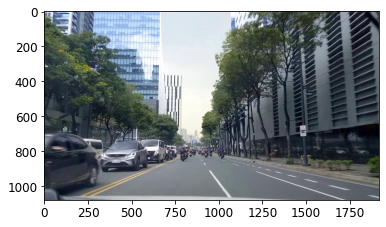

In [ ]:
# Automatic brightness and contrast optimization with optional histogram clipping
# Source from https://stackoverflow.com/questions/56905592/automatic-contrast-and-brightness-adjustment-of-a-color-photo-of-a-sheet-of-pape/56909036

def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)
    
    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))
    
    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0
    
    # Locate left cut. 
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1
    
    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1
    
    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray) # Original Value: 255
    beta = -minimum_gray * alpha
    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    
    return (auto_result, alpha, beta)

image, alpha, beta = automatic_brightness_and_contrast(image)
plt.imshow(fixColor(image)) 

### Convert image to grayscale and smoothen the image

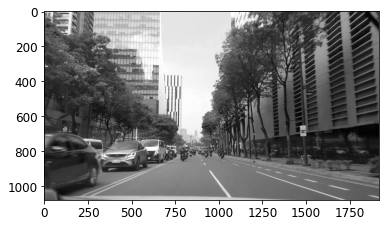

In [ ]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (3,3), 0)
plt.imshow(fixColor(gray))

## Segmentation (Thresholding)

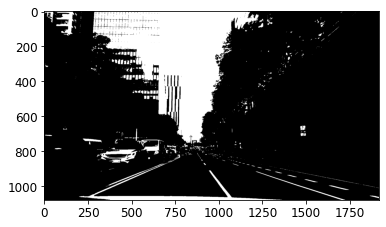

In [ ]:
ret,th = cv2.threshold(gray, 165, 1000, cv2.THRESH_BINARY)
plt.imshow(th, 'gray')

## Create edges with Canny Edge Detector

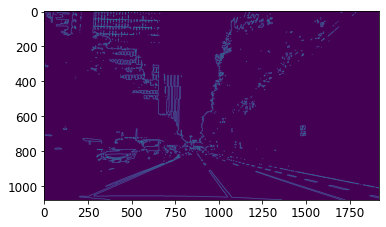

In [ ]:
edges = cv2.Canny(th, 25, 150)
plt.imshow(edges)

##Road Masking 

Get the hough lines from the target area which is the road. Dilate the markings since they are too thin.  

Create a polygon to mask the images with the edges

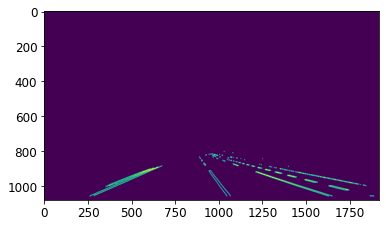

In [ ]:
# For masking part source: https://blog.paperspace.com/understanding-hough-transform-lane-detection/

height = edges.shape[0]
polygons = np.array([[(0, height-25), (1950, height-25), (1500, 800), (1000, 800)]])
mask = np.zeros_like(edges)
cv2.fillPoly(mask, polygons, 255)
masked_image = cv2.bitwise_and(edges, mask)
masked_image = cv2.dilate(masked_image, (5,5), iterations=3)
plt.imshow(masked_image)

## Apply HoughLines

We will apply Hough lines. The parameted used are as follows

1. edges: Output of the edge detector.
2. lines: A vector to store the coordinates of the start and end of the line.
3. rho: The resolution parameter \rho in pixels.
4. theta: The resolution of the parameter \theta in radians.
5. threshold: The minimum number of intersecting points to detect a line.

Hough transforms models lines in its polar coordinate form 
rho = x*cos(theta) + y*sin(theta)

Each pixel on an edge is mapped to lines which are represented theta and rhos. If the distance of an edge point is less maxLineGap, then it is assumed that edge lies on that line. The lines which has edge pixels greater than a minLineLength are finally identified and saved.

In [ ]:
# For houghline: https://blog.paperspace.com/understanding-hough-transform-lane-detection/
lines = cv2.HoughLinesP(masked_image, rho=1, theta=np.pi/180, threshold=200, minLineLength=100, maxLineGap=100)

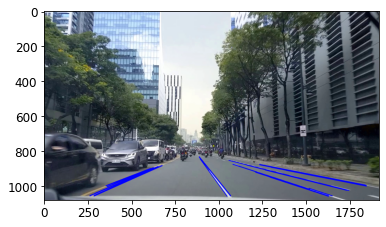

In [ ]:
image = image.copy()
for line in lines:
    x1, y1, x2, y2 = line[0]
    if (y1 > 825 and y2 > 825): # Filter out the lines in the top of the image
        cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 3)

plt.imshow(fixColor(image))

##Perspective Transform

Make the image angled from a top-view to make the lines more

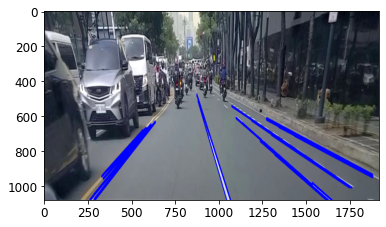

In [ ]:
height, width, channels = image.shape

pts1 = np.float32([[width/8, 700],    # top right
                   [width/8*7, 700],   # top left
                   [0, height-25],  # bottom left
                   [width, height-25]])  # bottom right
pts2 = np.float32([[0,0], [width, 0], [0, height], [width, height]])

matrix = cv2.getPerspectiveTransform(pts1, pts2)
result = cv2.warpPerspective(image, matrix, (width, height))
plt.imshow(fixColor(result))

## Masking

Hough lines in the applied image are colored red.  A mask for color red will be applied on the image

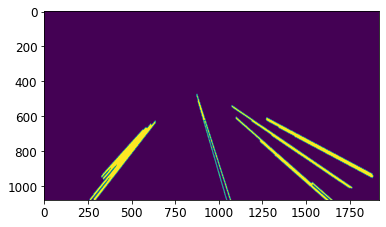

In [ ]:
hsvimg = cv2.cvtColor(result, cv2.COLOR_BGR2HSV)
hsv_color1 = np.asarray([0, 255, 255])  # Red
hsv_color2 = np.asarray([255,255,255])  # White
masker = cv2.inRange(hsvimg, hsv_color1,  hsv_color2)
plt.imshow(masker)

##Perspective Transform After Masking

Apply Bird's Eye View on road image. 
The img_size must be assumed to have a resolution of 1920x1080.

Source PTS are manually assigned to target the region of intererst.

[[ 480. 1080.]
 [1440. 1080.]
 [1440.    0.]
 [ 480.    0.]]


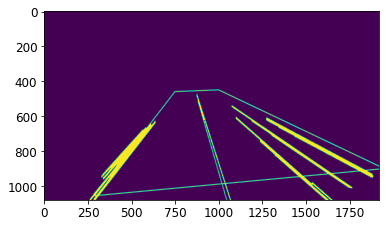

In [ ]:
#Source for capturing region of interest and warp https://towardsdatascience.com/computer-vision-for-lane-finding-24ea77f25209
masker1 = masker.copy()
img_size = (1920,1080)
offset = img_size[0]*0.25
PRES_SRC_PNTS = np.float32(
    [[290, height-25],
    [1950, 900],
    [1000, 450],
    [750, 460]])

PRES_DST_PNTS = np.float32([
    [offset,img_size[1]], #bottom left
    [img_size[0] - offset, img_size[1]], #bottom right
    [img_size[0] - offset, 0], #top right
    [offset,0] #top left
    ])

print(PRES_DST_PNTS)
plt.imshow(cv2.polylines(masker1, np.int32([PRES_SRC_PNTS]), True, (255,0,0), 3));

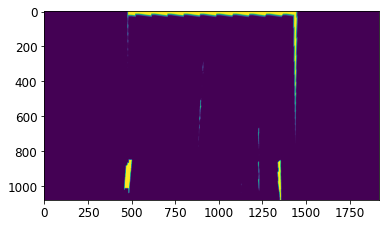

In [ ]:
M = cv2.getPerspectiveTransform(PRES_SRC_PNTS, PRES_DST_PNTS)
M_INV = cv2.getPerspectiveTransform(PRES_DST_PNTS, PRES_SRC_PNTS)
warped = cv2.warpPerspective(masker1, M, img_size, flags=cv2.INTER_LINEAR)
warped_cp = warped.copy()
erosion_dst = cv2.erode(warped_cp , np.ones((19, 19), np.uint8))
warped_poly = cv2.polylines(warped_cp, np.int32([PRES_DST_PNTS]), True, (255,0,0), 3)

plt.imshow(erosion_dst)

##Thresholding with colorspaces
Lab channel has lightness intensity.

In [ ]:
#source for combining b and L channels for thresholding: https://github.com/Moataz-E/computer-vision-lane-finding/blob/master/project_4_lane_finding.ipynb
B_CHANNEL_THRESH = (150, 200)
L2_CHANNEL_THRESH = (225, 255)
def seperate_lab(rgb_img):
    lab = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2Lab)
    l = lab[:,:,0]
    a = lab[:,:,1]
    b = lab[:,:,2]
    return l, a, b

def seperate_luv(rgb_img):
    luv = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2Luv)
    l = luv[:,:,0]
    u = luv[:,:,1]
    v = luv[:,:,2]
    return l, u, v

def binary_threshold_lab_luv(rgb_img, bthresh, lthresh):
    l, a, b = seperate_lab(rgb_img)
    l2, u, v = seperate_luv(rgb_img)
    binary = np.zeros_like(l)
    binary[
        ((b > bthresh[0]) & (b <= bthresh[1])) |
        ((l2 > lthresh[0]) & (l2 <= lthresh[1]))
    ] = 1
    return binary

## Finding peaks using thresholding, warp, histogram, avitzky-golay filter, and find_peaks_cwt function

1. Apply binary thresholding with channels of Lab and LUV. 
2. Apply Warp of binary image to eagle eye view
3. Apply histogram 
4. Apply  Savitzky-Golay filter (A low-pass filter that uses least squares to convert small range of data to a polynomial, then it asists in estimating a point to the window center which makes every point adjust relative to its surrounding points). This will reduce false peaks as the signals will be smoothen. 
5. A convolving wavelet transforrmation to find the peaks

Text(0.5, 1.0, 'Histogram with Plotted Peaks')

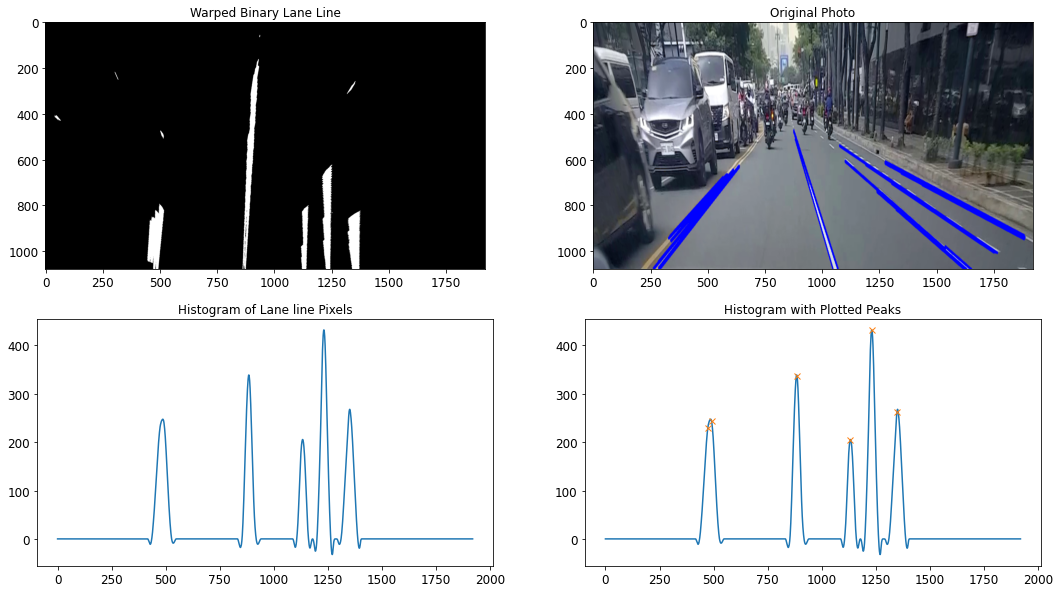

In [ ]:
from scipy.signal import find_peaks_cwt
from scipy.signal import savgol_filter

s_binary = binary_threshold_lab_luv(result, B_CHANNEL_THRESH, L2_CHANNEL_THRESH)
binary_warped = cv2.warpPerspective(s_binary, M, img_size, flags=cv2.INTER_LINEAR)

histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
histogram = savgol_filter(histogram, 59, 3) # Smoothen to reduce number of false peaks

peaks = find_peaks_cwt(histogram, widths=np.ones(histogram.shape)*2)-1 #find peaks

f, axarr = plt.subplots(2,2)
f.set_size_inches(18, 10)

axarr[0,0].imshow(binary_warped, cmap='gray')
axarr[0,0].set_title("Warped Binary Lane Line")

axarr[0,1].imshow(fixColor(result))
axarr[0,1].set_title("Original Photo")

axarr[1,0].plot(histogram)
axarr[1,0].set_title("Histogram of Lane line Pixels")

axarr[1,1].plot(histogram)
axarr[1,1].plot(peaks, histogram[peaks], "x")
axarr[1,1].set_title("Histogram with Plotted Peaks")



* After using savgol_filter on histogran, 10 peaks have been reduced to 6 peaks.

<br>

* There should be 5 peaks only since there are 5 lane markings, but there are additional peaks shown in the first signal due to the thickness of the clustered lane marking despite preprocessing or filtering.

<br>


---


Custom algorithm to remove repetitive peaks in each signal


---


<br>

*   Get the first digit 
(Assume that lane markings pixels start are between x=> 100 & x <=1899)

<br>

*   The first detected peak will extract its first digit then append its index.

<br>

*   It will ignore the next detected peaks until the first digit is a new number (assume that repetitive peaks fall under the same hundredth or both hundred-and-thousand digit)

<br>

*   i.e. Repetitive peaks are between 100-199, 200-299, 1800-1899, etc., but lane markings warped in the image varies a lot in the x-axis
so this cannot be adaptive for every image especially when position of captured image changes lanes in the road

<br>





##Peak Extraction
1. Each first detected peak of every lane marking signal in the histogram channel will be extracted since there is possible remaining false detected peaks or repetitive ones within each signal.

In [ ]:
# Not a perfect algorithm, preferrably recommend to preprocess or filter the histogram signal better 
# to find ONLY ONE peak per lane marking signal

print(f"Peaks: {peaks}")

fpeaklaneindices = []
lastdigit=-1
for i in (range(len(peaks))):
  fdigit = int(peaks[i] / 100)

  if (i != len(peaks)-1):
    fdigit2 = int(peaks[i+1] / 100)
  else:
    fdigit2 = -1

  if (i == 0):
    fpeaklaneindices.append(i)
  elif (fdigit != fdigit2 and lastdigit != fdigit):
    fpeaklaneindices.append(i)
  elif (lastdigit != fdigit):
    fpeaklaneindices.append(i)

  lastdigit = fdigit

print(f"Find peak lane indices: {fpeaklaneindices}")

Peaks: [ 473  491  886 1133 1231 1348]
Find peak lane indices: [0, 2, 3, 4, 5]


In [ ]:
chosenpeaks = []

for i in fpeaklaneindices:
  chosenpeaks.append(peaks[i])

print(f"Chosen peaks: {chosenpeaks}")  

Chosen peaks: [473, 886, 1133, 1231, 1348]


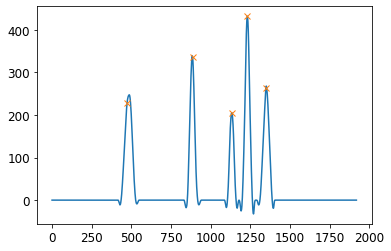

In [ ]:
plt.plot(histogram)
plt.plot(chosenpeaks, histogram[chosenpeaks], "x") 

## Check the bike lane exists or not

###Number of Lanes
---
Based on number of peaks per signal of lane marking

In [ ]:
LaneMarkings = len(chosenpeaks)
NumOfLanes = LaneMarkings - 1   
                                 
print(f"Number of Lanes: {NumOfLanes}") 

Number of Lanes: 4


### Width of every lane
---
NOTE: The distance calculated between the peaks are not exactly yet ground-truth width of the lane. There should be depth estimation to calculate the pixel relative to the camera position.  

In [ ]:
distances = chosenpeaks.copy()
distList = []

for i in range(len(chosenpeaks)-1):
  distList.append(abs(distances[i] - chosenpeaks[i+1]))

print(f"Width of lanes: {distList}")

Width of lanes: [413, 247, 98, 117]


### Results if `bike lane is present or not`

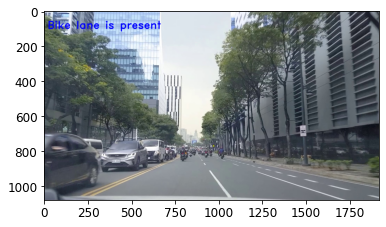

In [ ]:
if NumOfLanes >= 3:
  text = "Bike lane is present" if distList[-1] <= 200 else "Bike lane is not present"
else:
  text = "Bike lane is not present"

x, y, w, h = 0, 0, 200, 150
cv2.putText(copy_img, text=text, org=(x + int(w/10), y + int(h/1.5)), fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=2, color=(255,0,0), thickness=4)
plt.imshow(fixColor(copy_img))